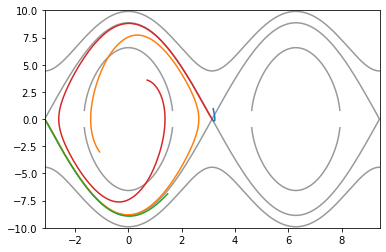

In [5]:
import argparse
import math
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

from pydrake.all import (DiagramBuilder, FloatingBaseType, Linearize,
                         LinearQuadraticRegulator, RigidBodyTree,
                         Saturation, SignalLogger, Simulator, wrap_to,
                         VectorSystem)
from pydrake.examples.pendulum import (PendulumInput, PendulumParams,
                                       PendulumPlant, PendulumState)


def TotalEnergy(state, params):
    theta = state[0]
    thetadot = state[1]
    total_energy = .5 * params.mass() \
        * math.pow(params.length() * thetadot, 2) \
        - params.mass() * params.gravity() * params.length() * math.cos(theta)
    return total_energy


def UprightState():
    state = PendulumState()
    state.set_theta(math.pi)
    state.set_thetadot(0.)
    return state


def BalancingLQR():
    # Design an LQR controller for stabilizing the Acrobot around the upright.
    # Returns a (static) AffineSystem that implements the controller (in
    # the original AcrobotState coordinates).

    pendulum = PendulumPlant()
    context = pendulum.CreateDefaultContext()

    input = PendulumInput()
    input.set_tau(0.)
    context.FixInputPort(0, input)

    context.get_mutable_continuous_state_vector()\
        .SetFromVector(UprightState().CopyToVector())

    Q = np.diag((10., 1.))
    R = [1]

    linearized_pendulum = Linearize(pendulum, context)
    (K, S) = LinearQuadraticRegulator(linearized_pendulum.A(),
                                      linearized_pendulum.B(),
                                      Q, R)
    return (K, S)


class SwingUpAndBalanceController(VectorSystem):
    def __init__(self):
        VectorSystem.__init__(self, 2, 1)
        (self.K, self.S) = BalancingLQR()
        self.params = PendulumParams()  # TODO(russt): Pass these in?

        # TODO(russt): Add a witness function to tell the simulator about the
        # discontinuity when switching to LQR.

    def DoCalcVectorOutput(self, context, pendulum_state, unused, output):

        xbar = copy(pendulum_state)
        xbar[0] = wrap_to(xbar[0], 0, 2.*math.pi) - math.pi

        # If x'Sx <= 2, then use the LQR controller
        if (xbar.dot(self.S.dot(xbar)) < 2.):
            output[:] = -self.K.dot(xbar)
        else:
            theta = pendulum_state[0]
            thetadot = pendulum_state[1]

            total_energy = TotalEnergy(pendulum_state, self.params)
            desired_energy = TotalEnergy(UprightState().CopyToVector(),
                                         self.params)
            output[:] = self.params.damping() * thetadot - \
                .1 * thetadot * (total_energy - desired_energy)


def PhasePlot(pendulum):
    phase_plot = plt.figure()
    ax = phase_plot.gca()
    theta_lim = [-math.pi, 3.*math.pi]
    ax.set_xlim(theta_lim)
    ax.set_ylim(-10., 10.)

    params = PendulumParams()
    theta = np.linspace(theta_lim[0], theta_lim[1], 601)  # 4*k + 1
    thetadot = np.zeros(theta.shape)
    E_upright = TotalEnergy(UprightState().CopyToVector(), params)
    E = [E_upright, .1*E_upright, 1.5*E_upright]
    for e in E:
        for i in range(theta.size):
            v = (e + params.mass() * params.gravity() * params.length() *
                 math.cos(theta[i])) / \
                (.5 * params.mass() * params.length() * params.length())
            if (v >= 0):
                thetadot[i] = math.sqrt(v)
            else:
                thetadot[i] = float('nan')
        ax.plot(theta, thetadot, color=[.6, .6, .6])
        ax.plot(theta, -thetadot, color=[.6, .6, .6])

    return ax


builder = DiagramBuilder()

pendulum = builder.AddSystem(PendulumPlant())
ax = PhasePlot(pendulum)
saturation = builder.AddSystem(Saturation(min_value=[-3],
                                          max_value=[3]))
builder.Connect(saturation.get_output_port(0), pendulum.get_input_port(0))
controller = builder.AddSystem(SwingUpAndBalanceController())
builder.Connect(pendulum.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0),
                saturation.get_input_port(0))

#    visualizer = builder.AddSystem(PendulumVisualizer())
#    builder.Connect(pendulum.get_output_port(0), visualizer.get_input_port(0))

logger = builder.AddSystem(SignalLogger(2))
builder.Connect(pendulum.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

# parser = argparse.ArgumentParser()
# parser.add_argument("-N", "--trials",
#                     type=int,
#                     help="Number of trials to run.",
#                     default=10)
# parser.add_argument("-T", "--duration",
#                     type=float,
#                     help="Duration to run each sim.",
#                     default=4.0)
# args = parser.parse_args()

duration = 5
trials = 5


# print("Click in the figure to advance.")
for i in range(trials):
    # plt.waitforbuttonpress()
    context.SetTime(0.)
    context.SetContinuousState(UprightState().CopyToVector() +
                               math.pi*np.random.randn(2,))
    simulator.StepTo(duration)
    ax.plot(logger.data()[0, :], logger.data()[1, :])
    # plt.pause(0.001)
    logger.reset()

# useful to zoom in on LQR solution:
# ax.set_xlim(math.pi-1.,math.pi+1.)
# ax.set_ylim(-1.,1.)

# print("That's it.  Close the figure window when you're done.")
plt.show()